In [1]:
# to import from parent directory
import os
import sys
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, SequentialSampler, Subset
from utils import get_lags, get_average, TrainHelper, Window, ExtendedDataset, evaluate_on_test, init_weights, save_obj, load_obj, remove_nan

In [3]:
full = pd.read_csv('../normalised_growth.csv', index_col=0, header=[0], parse_dates=True)

In [4]:
# start from 1960
full.drop(columns=['A191RL1Q225SBEA'], inplace=True)
full = full.loc["1960-01-01":]
full = remove_nan(full)
print(full.shape)

INTDSRUSM193N
ISRATIO
MTSDS133FMS
T10Y2YM
USSLIND
GFDEGDQ188S
GS20
MCOILWTICO
TCU
TOTALSA
(709, 21)


In [16]:
class GRUNet(nn.Module):
    def __init__(self, input_size, lags, hidden_size):
        super(GRUNet, self).__init__()
        self.lags = lags
        self.hidden_size = hidden_size
        self.input_size = input_size
        
        # input_size should match that in forward method
        self.gru = nn.GRU(input_size=input_size, hidden_size=hidden_size)
        self.fc1 = nn.Linear(hidden_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, 3)
        
    def forward(self, x):
        # input to lstm layer is (seq_len, batch, input_size)
        x, hidden = self.gru(x.view(self.lags, 1, self.input_size))
        # we only care about the output of the hidden
        hidden = F.relu(self.fc1(hidden))
        hidden = self.fc2(hidden)
        return hidden

In [12]:
trainer = TrainHelper(percent = 0.99, manual = 5000, print_every=1000)

PATH = "./GRU Extended One Layer/"

def train_times(times, trainer, net, criterion, optimizer, window):
    
    losses = []

    # train ten times, find best loss
    for i in range(times):
        net.apply(init_weights)
        print("Training %d time" % i)
        loss = trainer.train_window(net, criterion, optimizer, window)
        torch.save(net.state_dict(), PATH + "lag" + str(net.lags) + "hidden" + str(net.hidden_size) + "_" + str(i) + ".pt")
        losses.append(loss)
        
    return losses

In [6]:
length = len(full)
val_start = round(length * 0.8)
test_start = round(length * 0.9)
print(length)

709


In [14]:
losses = {}

In [18]:
hiddens = [30]

for lags in range(1, 6):
    data = ExtendedDataset(full, lags=lags, series=["CPIAUCSL", "A191RO1Q156NBEA", "UNRATE"])

    # subtract by lags to ensure same training sets
    trainset = Subset(data, [i for i in range(val_start - 1 - lags)])
    valset = Subset(data, [i for i in range(val_start - lags, test_start - 1 - lags)])

    trainloader = DataLoader(trainset, batch_size=1, shuffle=False, sampler=SequentialSampler(trainset))
    validationloader = DataLoader(valset, batch_size=1, shuffle=False, sampler=SequentialSampler(valset))

    window = Window(trainloader, validationloader)
    
    for hidden_size in hiddens:
        print("Training new net, %d lags %d hidden" % (lags, hidden_size))

        net = GRUNet(lags=lags, hidden_size=hidden_size, input_size = full.shape[1])
        criterion = nn.MSELoss()
        optimizer = optim.SGD(net.parameters(), lr=0.001)
        loss = train_times(10, trainer, net, criterion, optimizer, window)
        print(loss)
        losses[str(lags) + "-" + str(hidden_size)] = loss
    

Training new net, 1 lags 30 hidden
Training 0 time
[epoch: 1] train loss: 0.755, val loss: 1.198
Finished window, trained for 51 epochs, loss: 0.303
Training 1 time
[epoch: 1] train loss: 0.804, val loss: 1.433
Finished window, trained for 39 epochs, loss: 0.426
Training 2 time
[epoch: 1] train loss: 0.623, val loss: 1.005
Finished window, trained for 31 epochs, loss: 0.446
Training 3 time
[epoch: 1] train loss: 0.522, val loss: 1.034
Finished window, trained for 34 epochs, loss: 0.317
Training 4 time
[epoch: 1] train loss: 0.625, val loss: 1.322
Finished window, trained for 32 epochs, loss: 0.319
Training 5 time
[epoch: 1] train loss: 0.772, val loss: 1.249
Finished window, trained for 38 epochs, loss: 0.329
Training 6 time
[epoch: 1] train loss: 0.631, val loss: 0.965
Finished window, trained for 27 epochs, loss: 0.386
Training 7 time
[epoch: 1] train loss: 0.605, val loss: 1.405
Finished window, trained for 32 epochs, loss: 0.378
Training 8 time
[epoch: 1] train loss: 0.422, val los

In [20]:
best_loss = []
avg_loss = []

for k, v in losses.items():
    best_net_index = np.argmin(v)
    best_loss.append(v[best_net_index])
    avg_loss.append(get_average(v))

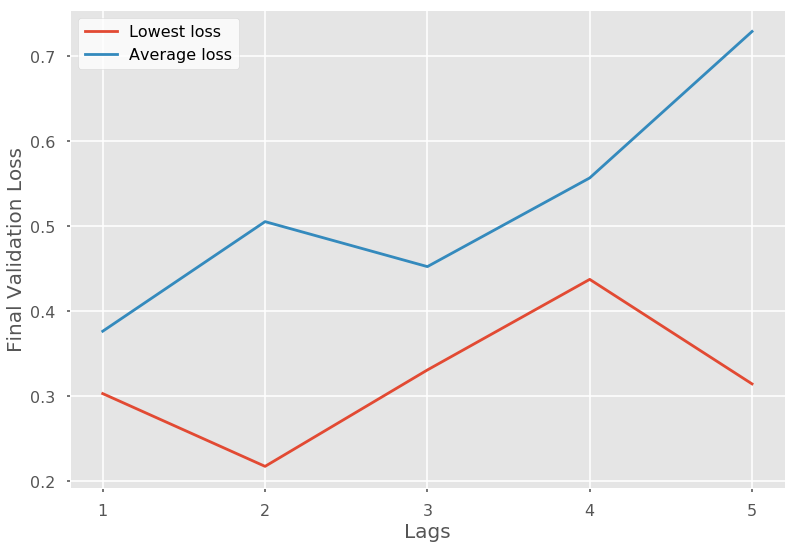

In [24]:
from matplotlib import style

style.use('seaborn-poster') #sets the size of the charts
style.use('ggplot')

# plt.figure(figsize=(15,10))

plt.plot([i for i in range(1, len(best_loss) + 1)], best_loss)
plt.plot([i for i in range(1, len(best_loss) + 1)], avg_loss)

plt.xticks([1, 2, 3, 4, 5])

plt.legend(("Lowest loss", "Average loss"), facecolor="white")
plt.xlabel("Lags", fontsize=20)
plt.ylabel("Final Validation Loss", fontsize=20)
plt.savefig('../Figs/lags_gru_extended.png', bbox_inches='tight')

In [19]:
save_obj(losses, "GRU_Extended_One_Layer")